In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        (os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

2024-05-10 02:49:36.500726: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-10 02:49:36.500818: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-10 02:49:36.626443: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
dataset_path = '/kaggle/input/felidae-tiger-lion-cheetah-leopard-puma/Felidae'

In [4]:
from pathlib import Path
from collections import Counter

dataset_path = Path(dataset_path)

In [5]:
paths = list(dataset_path.glob('*/*'))
classes = dict(Counter([path.parent.stem for path in paths]))
extensions = dict(Counter([path.suffix for path in paths]))
classes, extensions

({'Cheetah': 56, 'Lion': 49, 'Tiger': 48, 'Puma': 40, 'Leopard': 50},
 {'.jpg': 243})

In [6]:
# check dataset for non-jpg even though they have .jpg extension files:
from PIL import Image

formats = []
for path in paths:
    im = Image.open(path)
    formats.append(im.format)
    im.close()
    
Counter(formats)

Counter({'JPEG': 180, 'WEBP': 61, 'PNG': 2})

In [7]:
# tensorflow cannot handle webp images
# converting webp and png to jpg

new_ds_path = Path('./NewDataset')
new_ds_path.mkdir(parents=True, exist_ok=True)
for c in classes:
    class_path = new_ds_path / c
    class_path.mkdir(parents=True, exist_ok=True)

In [8]:
!tree

.
|-- NewDataset
|   |-- Cheetah
|   |-- Leopard
|   |-- Lion
|   |-- Puma
|   `-- Tiger
`-- __notebook__.ipynb

6 directories, 1 file


In [9]:
for path in paths:
    im = Image.open(path)
    im = im.convert(mode='RGB')
    class_name = path.parent.stem
    file_name = path.stem
    fp = new_ds_path.joinpath(class_name).joinpath(file_name)
    fp = fp.parent / (fp.name + '.jpg')
#     print(fp)
    im.save(fp, format='JPEG')

In [10]:
class Config:
    batch_size = 16
    img_dim = (224,224)
    epochs = 20

In [11]:
dataset_path = Path('./NewDataset')


In [12]:
train_ds = keras.utils.image_dataset_from_directory(dataset_path,
                                                    subset = 'training',
                                                    validation_split = 0.2,
                                                    image_size = Config.img_dim,
                                                    batch_size = Config.batch_size,
                                                    seed=1
                                                   )

val_ds = keras.utils.image_dataset_from_directory(dataset_path,
                                                  subset = 'validation',
                                                  validation_split = 0.2,
                                                  image_size = Config.img_dim, 
                                                  batch_size = Config.batch_size,
                                                  seed=1
                                                 )

Found 243 files belonging to 5 classes.
Using 195 files for training.
Found 243 files belonging to 5 classes.
Using 48 files for validation.


In [13]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(*Config.img_dim, 3)),
    layers.RandomContrast(0.2),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.3)
  ]
)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
model = Sequential([
    Rescaling(1./255,  input_shape=(*Config.img_dim, 3)),
    Conv2D(16, 3, activation='relu',),
    MaxPooling2D(),
    Conv2D(32, 3, activation='relu'),
    MaxPooling2D(),
    Conv2D(128, 3, activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(5)
])

In [15]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    88,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,347,749 (340.83 MB)

 Trainable params: 89,347,749 (340.83 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
model.compile(optimizer='adam', 
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])
             

In [17]:
history = model.fit(train_ds, validation_data=val_ds, epochs=50)


Epoch 1/50


2024-05-10 02:50:04.893815: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49293: 7.29743, expected 6.46071
2024-05-10 02:50:04.893881: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49294: 7.12612, expected 6.2894
2024-05-10 02:50:04.893891: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49295: 5.65411, expected 4.81739
2024-05-10 02:50:04.893898: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49346: 6.79266, expected 5.95594
2024-05-10 02:50:04.893906: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49349: 7.1312, expected 6.29448
2024-05-10 02:50:04.893914: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49350: 6.42717, expected 5.59045
2024-05-10 02:50:04.893922: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49351: 6.82348, expected 5.98675
2024-05-10 02:50:04.893929: E

 3/13 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.2361 - loss: 1.8137 

I0000 00:00:1715309411.579765      73 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1715309411.599789      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


10/13 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2272 - loss: 1.7777

2024-05-10 02:50:12.357835: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 98575: 5.43691, expected 4.77741
2024-05-10 02:50:12.357887: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 98579: 3.67762, expected 3.01812
2024-05-10 02:50:12.357896: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 98580: 4.99196, expected 4.33247
2024-05-10 02:50:12.357904: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 98581: 5.33892, expected 4.67942
2024-05-10 02:50:12.357911: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 98595: 4.74109, expected 4.0816
2024-05-10 02:50:12.357919: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 98596: 4.75532, expected 4.09583
2024-05-10 02:50:12.357926: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 98600: 5.09651, expected 4.43701
2024-05-10 02:50:12.357934: 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.2243 - loss: 1.7621

W0000 00:00:1715309416.105762      75 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 445ms/step - accuracy: 0.2244 - loss: 1.7580 - val_accuracy: 0.2917 - val_loss: 2.3624
Epoch 2/50


W0000 00:00:1715309416.938158      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.2585 - loss: 2.0024 - val_accuracy: 0.1458 - val_loss: 1.6303
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.1805 - loss: 1.6326 - val_accuracy: 0.2500 - val_loss: 1.6779
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.1657 - loss: 1.7172 - val_accuracy: 0.2917 - val_loss: 2.8938
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.1969 - loss: 2.0744 - val_accuracy: 0.2292 - val_loss: 1.6505
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.1446 - loss: 1.8303 - val_accuracy: 0.1667 - val_loss: 1.7399
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.2341 - loss: 1.7368 - val_accuracy: 0.1875 - val_loss: 1.6534
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.1858 - loss: 1.6443 - val_accuracy: 0.1042 - val_loss: 1.7509
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.1696 - loss: 1.6801 - val_accuracy: 0.2292 - val_loss: 1.

In [18]:
def plot_loss_curves(history):

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  #plot loss
  plt.plot(epochs, loss, label = "training_loss")
  plt.plot(epochs, val_loss, label = "val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  #plot accuracy
  plt.figure() 
  plt.plot(epochs, accuracy, label = "training_accuracy")
  plt.plot(epochs, val_accuracy, label = "val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

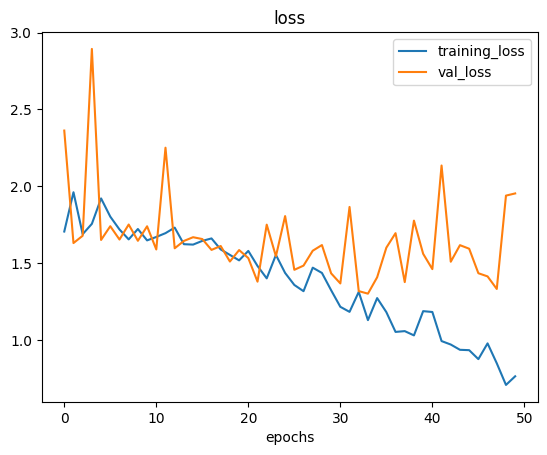

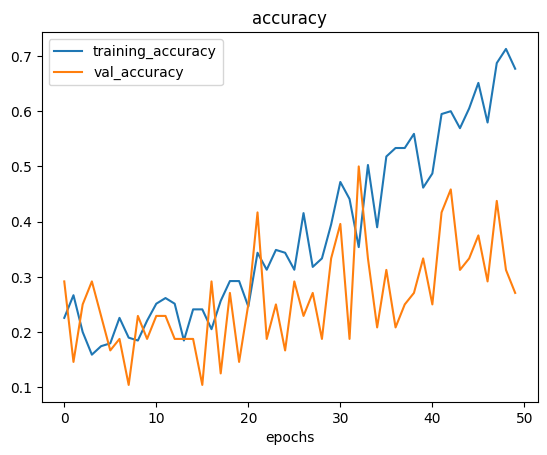

In [19]:
plot_loss_curves(history)